In [1]:
import torch
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    GPT2Config,
    GPT2LMHeadModel
)
import math

# --- 1. Data Loading and Saving (Ensuring full_text is populated) ---
print("--- Step 1: Data Loading and Saving ---")
# Load WikiText-2 raw dataset
dataset_raw = load_dataset("wikitext", "wikitext-2-raw-v1")



2025-06-23 21:55:38.293458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750695938.304828    9403 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750695938.308248    9403 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750695938.318358    9403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750695938.318375    9403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750695938.318377    9403 computation_placer.cc:177] computation placer alr

--- Step 1: Data Loading and Saving ---


In [2]:
# Concatenate all splits (train, validation, test) into a single string
# This prepares a single text file for language modeling training
full_text = ""
for split_name in dataset_raw.keys():
    full_text += "\n".join(dataset_raw[split_name]["text"]) + "\n"

# Save the concatenated text to a file
# The Trainer will load from this file and handle train/eval split later
text_file_path = "wikitext_full_dataset.txt" # Changed filename for clarity
with open(text_file_path, "w", encoding="utf-8") as f:
    f.write(full_text)

print(f"✅ WikiText saved as '{text_file_path}' for fine-tuning.")


✅ WikiText saved as 'wikitext_full_dataset.txt' for fine-tuning.


In [3]:
# --- 2. Load Dataset from File and Tokenize ---
print("\n--- Step 2: Loading Data and Tokenization ---")
# Load the dataset from your saved text file
dataset = load_dataset("text", data_files={"train": text_file_path})

# Load GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# GPT-2 does not have a dedicated pad token by default, use eos_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"Set tokenizer.pad_token to tokenizer.eos_token: {tokenizer.pad_token}")

# Tokenize the dataset
def tokenize_function(examples):
    # Use truncation=True to handle texts longer than tokenizer's max length
    # This ensures that very long lines don't break the tokenizer
    return tokenizer(examples["text"], return_special_tokens_mask=True, truncation=True)

tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    num_proc=4, # Use multiple processes for faster tokenization
    remove_columns=["text"]
)



--- Step 2: Loading Data and Tokenization ---


Generating train split: 0 examples [00:00, ? examples/s]

/home/dharun/Desktop/wikitext/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Set tokenizer.pad_token to tokenizer.eos_token: <|endoftext|>


Map (num_proc=4):   0%|          | 0/73955 [00:00<?, ? examples/s]

In [4]:
# Define block_size for grouping texts (crucial for context)
# Increased from 128 to 512 for better performance on long dependencies
block_size = 512 # Increased context length

def group_texts(examples):
    # Concatenate all texts from a batch
    concatenated_input_ids = sum(examples["input_ids"], [])
    concatenated_attention_mask = sum(examples["attention_mask"], [])

    # Compute length of concatenated tokens and truncate to a multiple of block_size
    total_length = (len(concatenated_input_ids) // block_size) * block_size

    # Split into chunks of block_size
    result = {
        "input_ids": [concatenated_input_ids[i:i + block_size] for i in range(0, total_length, block_size)],
        "attention_mask": [concatenated_attention_mask[i:i + block_size] for i in range(0, total_length, block_size)],
    }
    # For causal language modeling, labels are the same as input_ids
    result["labels"] = result["input_ids"].copy()
    return result

# Remove special_tokens_mask as it's not needed for CLM training
tokenized_datasets = tokenized_datasets.remove_columns(['special_tokens_mask'])

In [5]:
# Group texts into fixed-size blocks
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=4 # Use multiple processes for faster grouping
)

# Split into training and validation sets
# Use a DatasetDict to easily access train and validation splits by name
split_datasets = lm_datasets["train"].train_test_split(test_size=0.05, seed=42) # Smaller validation set is fine
lm_datasets = DatasetDict({
    "train": split_datasets["train"],
    "validation": split_datasets["test"]
})

print(f"Training dataset size: {len(lm_datasets['train'])}")
print(f"Validation dataset size: {len(lm_datasets['validation'])}")
print("First example from training dataset:", lm_datasets["train"][0])


Map (num_proc=4):   0%|          | 0/73955 [00:00<?, ? examples/s]

Training dataset size: 5336
Validation dataset size: 281
First example from training dataset: {'input_ids': [837, 290, 734, 1588, 16842, 13431, 547, 6589, 355, 636, 286, 262, 1218, 3800, 286, 607, 11315, 764, 383, 4074, 5952, 10256, 287, 24927, 9992, 1262, 262, 1468, 2679, 24927, 657, 2488, 12, 31, 352, 357, 409, 2488, 12, 31, 471, 2488, 12, 31, 13151, 1267, 764, 554, 1737, 35768, 837, 1081, 32810, 373, 18235, 351, 257, 8190, 2488, 12, 31, 2366, 2488, 12, 31, 604, 2488, 12, 31, 11111, 357, 678, 285, 1267, 25388, 2488, 12, 31, 1633, 6215, 48786, 319, 607, 11092, 293, 290, 7675, 5611, 281, 412, 17, 45, 16, 5994, 1315, 5417, 14382, 764, 2293, 5100, 17390, 837, 262, 48786, 373, 6928, 416, 530, 13232, 416, 2485, 45855, 764, 1550, 262, 11939, 286, 4856, 287, 35768, 837, 1081, 32810, 373, 4624, 287, 11515, 764, 220, 797, 31691, 355, 257, 9185, 4074, 319, 1467, 2932, 28684, 837, 1081, 32810, 373, 2077, 503, 286, 11515, 287, 3389, 837, 706, 262, 16556, 49341, 10290, 32731, 326, 2067, 262, 5498,

In [6]:
# --- 3. Model Configuration (with optimized dropout) ---
print("\n--- Step 3: Model Configuration ---")
# Load GPT-2 config
config = GPT2Config.from_pretrained("gpt2")

# Adjust dropout for fine-tuning pre-trained models
# Lowered from 0.3 to 0.1, as high dropout can hinder fine-tuning.
config.attn_pdrop = 0.1     # Dropout in attention layers
config.resid_pdrop = 0.1    # Dropout in residual connections
config.embd_pdrop = 0.1     # Dropout in embedding layers



--- Step 3: Model Configuration ---


/home/dharun/Desktop/wikitext/lib/python3.12/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Load model with the modified config
model = AutoModelForCausalLM.from_pretrained("gpt2", config=config)
print("✅ GPT-2 model loaded with adjusted dropout rates.")

# --- 4. Data Collator ---
print("\n--- Step 4: Data Collator ---")
# Data collator for causal language modeling (CLM)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal LM like GPT-2 does NOT use masked LM
)
print("✅ DataCollatorForLanguageModeling configured.")


✅ GPT-2 model loaded with adjusted dropout rates.

--- Step 4: Data Collator ---
✅ DataCollatorForLanguageModeling configured.


In [8]:
# --- 5. Training Arguments ---
print("\n--- Step 5: Training Arguments Configuration ---")
# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-wikitext-fine-tuned", # Dedicated output directory
    save_strategy="epoch",
    evaluation_strategy="epoch",
    save_total_limit=2, # Keep only the last 2 best checkpoints
    logging_dir="./gpt2-wikitext-fine-tuned/logs",
    logging_steps=50, # Log more frequently to monitor progress
    per_device_train_batch_size=4, # Start with 4, increase if GPU allows
    gradient_accumulation_steps=8, # Simulate a larger batch size (4 * 8 = 32 effective batch size)
    num_train_epochs=15, # Increased epochs, but EarlyStopping will manage it
    learning_rate=3e-5, # Good range for fine-tuning
    weight_decay=0.01,
    load_best_model_at_end=True, # Automatically load the best model (lowest eval_loss)
    metric_for_best_model="eval_loss",
    max_grad_norm=1.0, # Gradient clipping for stability
    lr_scheduler_type="cosine", # Cosine annealing with warmup
    warmup_steps=500, # Increased warmup steps
    report_to="tensorboard" # Integrate with TensorBoard for visualization
)
print("✅ TrainingArguments configured.")


--- Step 5: Training Arguments Configuration ---
✅ TrainingArguments configured.


In [9]:
# --- 6. Initialize Trainer (with Early Stopping) ---
print("\n--- Step 6: Initializing Trainer ---")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # Add EarlyStoppingCallback to stop training if validation loss doesn't improve
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Stop if no improvement for 3 eval epochs
)
print("✅ Trainer initialized with EarlyStoppingCallback.")



--- Step 6: Initializing Trainer ---
✅ Trainer initialized with EarlyStoppingCallback.


In [10]:
# --- 7. Train Model ---
print("\n--- Step 7: Starting Training ---")
trainer.train()
print("✅ Training complete.")



--- Step 7: Starting Training ---


  0%|          | 0/2490 [00:00<?, ?it/s]

{'loss': 3.862, 'grad_norm': 4.302051544189453, 'learning_rate': 3e-06, 'epoch': 0.3}
{'loss': 3.6753, 'grad_norm': 2.9008195400238037, 'learning_rate': 6e-06, 'epoch': 0.6}
{'loss': 3.5308, 'grad_norm': 2.2389912605285645, 'learning_rate': 9e-06, 'epoch': 0.9}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.2945032119750977, 'eval_runtime': 8.0844, 'eval_samples_per_second': 34.758, 'eval_steps_per_second': 4.453, 'epoch': 1.0}
{'loss': 3.4659, 'grad_norm': 2.3160297870635986, 'learning_rate': 1.2e-05, 'epoch': 1.2}
{'loss': 3.403, 'grad_norm': 2.1176047325134277, 'learning_rate': 1.5e-05, 'epoch': 1.5}
{'loss': 3.3496, 'grad_norm': 2.2870118618011475, 'learning_rate': 1.8e-05, 'epoch': 1.8}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.1846091747283936, 'eval_runtime': 7.4392, 'eval_samples_per_second': 37.773, 'eval_steps_per_second': 4.839, 'epoch': 2.0}
{'loss': 3.3094, 'grad_norm': 2.0442724227905273, 'learning_rate': 2.1e-05, 'epoch': 2.1}
{'loss': 3.2998, 'grad_norm': 2.1923043727874756, 'learning_rate': 2.4e-05, 'epoch': 2.4}
{'loss': 3.277, 'grad_norm': 2.2128913402557373, 'learning_rate': 2.7000000000000002e-05, 'epoch': 2.7}
{'loss': 3.269, 'grad_norm': 1.9633338451385498, 'learning_rate': 3e-05, 'epoch': 3.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.1423165798187256, 'eval_runtime': 7.5432, 'eval_samples_per_second': 37.252, 'eval_steps_per_second': 4.773, 'epoch': 3.0}
{'loss': 3.2274, 'grad_norm': 2.088778018951416, 'learning_rate': 2.99532943567169e-05, 'epoch': 3.3}
{'loss': 3.2121, 'grad_norm': 2.055589437484741, 'learning_rate': 2.981346828248286e-05, 'epoch': 3.6}
{'loss': 3.2057, 'grad_norm': 2.0232508182525635, 'learning_rate': 2.9581392532863852e-05, 'epoch': 3.9}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.1181800365448, 'eval_runtime': 7.556, 'eval_samples_per_second': 37.189, 'eval_steps_per_second': 4.764, 'epoch': 4.0}
{'loss': 3.177, 'grad_norm': 1.8372331857681274, 'learning_rate': 2.9258512340816745e-05, 'epoch': 4.2}
{'loss': 3.166, 'grad_norm': 1.9272501468658447, 'learning_rate': 2.8846838416617912e-05, 'epoch': 4.5}
{'loss': 3.1568, 'grad_norm': 1.829816460609436, 'learning_rate': 2.8348934426327703e-05, 'epoch': 4.8}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.1009140014648438, 'eval_runtime': 7.5593, 'eval_samples_per_second': 37.173, 'eval_steps_per_second': 4.762, 'epoch': 5.0}
{'loss': 3.1467, 'grad_norm': 1.8881245851516724, 'learning_rate': 2.7767901026767422e-05, 'epoch': 5.1}
{'loss': 3.1135, 'grad_norm': 1.9252959489822388, 'learning_rate': 2.710735655642978e-05, 'epoch': 5.4}
{'loss': 3.1184, 'grad_norm': 1.7532596588134766, 'learning_rate': 2.637141450256868e-05, 'epoch': 5.7}
{'loss': 3.112, 'grad_norm': 1.8073619604110718, 'learning_rate': 2.5564657884790083e-05, 'epoch': 6.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.089832067489624, 'eval_runtime': 7.608, 'eval_samples_per_second': 36.935, 'eval_steps_per_second': 4.732, 'epoch': 6.0}
{'loss': 3.0753, 'grad_norm': 1.7612208127975464, 'learning_rate': 2.4692110714668146e-05, 'epoch': 6.3}
{'loss': 3.0833, 'grad_norm': 1.8495168685913086, 'learning_rate': 2.3759206709119596e-05, 'epoch': 6.6}
{'loss': 3.0813, 'grad_norm': 1.7634944915771484, 'learning_rate': 2.2771755452371164e-05, 'epoch': 6.9}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.0811989307403564, 'eval_runtime': 7.3012, 'eval_samples_per_second': 38.487, 'eval_steps_per_second': 4.931, 'epoch': 7.0}
{'loss': 3.0604, 'grad_norm': 1.8316516876220703, 'learning_rate': 2.1735906217243805e-05, 'epoch': 7.2}
{'loss': 3.0478, 'grad_norm': 1.7720528841018677, 'learning_rate': 2.0658109671053642e-05, 'epoch': 7.5}
{'loss': 3.0439, 'grad_norm': 1.845810055732727, 'learning_rate': 1.954507770460309e-05, 'epoch': 7.8}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.075378179550171, 'eval_runtime': 7.4012, 'eval_samples_per_second': 37.967, 'eval_steps_per_second': 4.864, 'epoch': 8.0}
{'loss': 3.0469, 'grad_norm': 1.7233290672302246, 'learning_rate': 1.8403741634423852e-05, 'epoch': 8.1}
{'loss': 3.0172, 'grad_norm': 1.690677285194397, 'learning_rate': 1.7241209038563914e-05, 'epoch': 8.4}
{'loss': 3.026, 'grad_norm': 1.8065249919891357, 'learning_rate': 1.606471949472024e-05, 'epoch': 8.7}
{'loss': 3.0199, 'grad_norm': 1.776986002922058, 'learning_rate': 1.4881599496354304e-05, 'epoch': 9.0}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.071117401123047, 'eval_runtime': 7.4554, 'eval_samples_per_second': 37.691, 'eval_steps_per_second': 4.829, 'epoch': 9.0}
{'loss': 3.0083, 'grad_norm': 1.7138186693191528, 'learning_rate': 1.369921682754674e-05, 'epoch': 9.3}
{'loss': 3.0033, 'grad_norm': 1.7475553750991821, 'learning_rate': 1.2524934680718013e-05, 'epoch': 9.6}
{'loss': 2.994, 'grad_norm': 1.7389147281646729, 'learning_rate': 1.1366065802943255e-05, 'epoch': 9.9}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.068293571472168, 'eval_runtime': 7.6427, 'eval_samples_per_second': 36.767, 'eval_steps_per_second': 4.71, 'epoch': 10.0}
{'loss': 2.9863, 'grad_norm': 1.8167427778244019, 'learning_rate': 1.0229826956411427e-05, 'epoch': 10.19}
{'loss': 2.9966, 'grad_norm': 1.77407705783844, 'learning_rate': 9.123293976622604e-06, 'epoch': 10.49}
{'loss': 2.9859, 'grad_norm': 1.6968311071395874, 'learning_rate': 8.053357708194785e-06, 'epoch': 10.79}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.0665159225463867, 'eval_runtime': 8.7091, 'eval_samples_per_second': 32.265, 'eval_steps_per_second': 4.134, 'epoch': 11.0}
{'loss': 2.9763, 'grad_norm': 1.6983251571655273, 'learning_rate': 7.026681092686481e-06, 'epoch': 11.09}
{'loss': 2.9784, 'grad_norm': 1.823476791381836, 'learning_rate': 6.049657675667161e-06, 'epoch': 11.39}
{'loss': 2.9768, 'grad_norm': 1.8553179502487183, 'learning_rate': 5.128371791429436e-06, 'epoch': 11.69}
{'loss': 2.9718, 'grad_norm': 1.6653168201446533, 'learning_rate': 4.268560673289432e-06, 'epoch': 11.99}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.065931797027588, 'eval_runtime': 7.4399, 'eval_samples_per_second': 37.769, 'eval_steps_per_second': 4.839, 'epoch': 12.0}
{'loss': 2.9837, 'grad_norm': 1.7383430004119873, 'learning_rate': 3.47557872543044e-06, 'epoch': 12.29}
{'loss': 2.9578, 'grad_norm': 1.769993543624878, 'learning_rate': 2.7543641787840142e-06, 'epoch': 12.59}
{'loss': 2.9627, 'grad_norm': 1.767242670059204, 'learning_rate': 2.10940833859632e-06, 'epoch': 12.89}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.0658957958221436, 'eval_runtime': 6.8499, 'eval_samples_per_second': 41.023, 'eval_steps_per_second': 5.256, 'epoch': 13.0}
{'loss': 2.9549, 'grad_norm': 1.7726629972457886, 'learning_rate': 1.5447276151880474e-06, 'epoch': 13.19}
{'loss': 2.9583, 'grad_norm': 1.773561716079712, 'learning_rate': 1.0638385120840416e-06, 'epoch': 13.49}
{'loss': 2.9739, 'grad_norm': 1.6700763702392578, 'learning_rate': 6.697357272720783e-07, 'epoch': 13.79}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.065166473388672, 'eval_runtime': 7.3851, 'eval_samples_per_second': 38.05, 'eval_steps_per_second': 4.875, 'epoch': 14.0}
{'loss': 2.9773, 'grad_norm': 1.7685621976852417, 'learning_rate': 3.64873503963396e-07, 'epoch': 14.09}
{'loss': 2.9524, 'grad_norm': 1.8922970294952393, 'learning_rate': 1.511503469916431e-07, 'epoch': 14.39}
{'loss': 2.9584, 'grad_norm': 1.7548623085021973, 'learning_rate': 2.989720002759877e-08, 'epoch': 14.69}


  0%|          | 0/36 [00:00<?, ?it/s]

{'eval_loss': 3.065197706222534, 'eval_runtime': 7.4688, 'eval_samples_per_second': 37.623, 'eval_steps_per_second': 4.82, 'epoch': 14.93}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


{'train_runtime': 6299.3692, 'train_samples_per_second': 12.706, 'train_steps_per_second': 0.395, 'train_loss': 3.1227745546394563, 'epoch': 14.93}
✅ Training complete.


In [11]:
# --- 8. Save the Best Model ---
print("\n--- Step 8: Saving the Best Model ---")
# The best model is automatically loaded into trainer.model because of load_best_model_at_end=True
best_model_save_path = "./gpt2-wikitext-best-model"
trainer.save_model(best_model_save_path)
tokenizer.save_pretrained(best_model_save_path)
print(f"✅ Best fine-tuned model and tokenizer saved to: {best_model_save_path}")


--- Step 8: Saving the Best Model ---
✅ Best fine-tuned model and tokenizer saved to: ./gpt2-wikitext-best-model


In [12]:
# --- 9. Evaluate Final Perplexity on Validation Set ---
print("\n--- Step 9: Final Perplexity Evaluation ---")
eval_results = trainer.evaluate()
perplexity = math.exp(eval_results["eval_loss"])
print(f"Final Validation Perplexity after fine-tuning: {perplexity:.4f}")
print("✅ Evaluation complete.")



--- Step 9: Final Perplexity Evaluation ---


  0%|          | 0/36 [00:00<?, ?it/s]

Final Validation Perplexity after fine-tuning: 21.4380
✅ Evaluation complete.


In [13]:

# --- 10. Test Next Word Prediction ---
print("\n--- Step 10: Testing Next Word Prediction ---")
# Load the best fine-tuned model and tokenizer for inference
loaded_tokenizer = AutoTokenizer.from_pretrained(best_model_save_path)
loaded_model = AutoModelForCausalLM.from_pretrained(best_model_save_path)
loaded_model.eval() # Set model to evaluation mode
 #Input prompt
prompt = "The history of India begins with the Indus Valley Civilization, which"
inputs = loaded_tokenizer(prompt, return_tensors="pt")

# Move inputs to the same device as the model (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Generate text (you can use generate() for more control, but direct logits for next token is fine)
with torch.no_grad():
    outputs = loaded_model(**inputs)
    logits = outputs.logits

# Get the logits for the last token
next_token_logits = logits[0, -1, :]

# Apply softmax to get probabilities
probs = torch.softmax(next_token_logits, dim=-1)

# Get the top 5 predicted next words
top_k = 5
top_k_probs, top_k_indices = torch.topk(probs, top_k)

# Decode the predicted tokens
predicted_words = [loaded_tokenizer.decode([idx.item()]) for idx in top_k_indices]

# Display predictions
print(f"\nPrompt: {prompt}")
print("Top predicted next words:")
for i, (word, prob) in enumerate(zip(predicted_words, top_k_probs)):
    print(f"{i+1}. '{word.strip()}' (probability: {prob.item():.4f})")

print("\n--- Project Execution Complete ---")



--- Step 10: Testing Next Word Prediction ---

Prompt: The history of India begins with the Indus Valley Civilization, which
Top predicted next words:
1. 'was' (probability: 0.1805)
2. 'flourished' (probability: 0.1413)
3. 'began' (probability: 0.0764)
4. 'is' (probability: 0.0565)
5. 'started' (probability: 0.0271)

--- Project Execution Complete ---


/tmp/ipykernel_9403/43764918.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=losses, ax=axes[0], palette='Blues_d')
/tmp/ipykernel_9403/43764918.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=perplexities, ax=axes[1], palette='Greens_d')


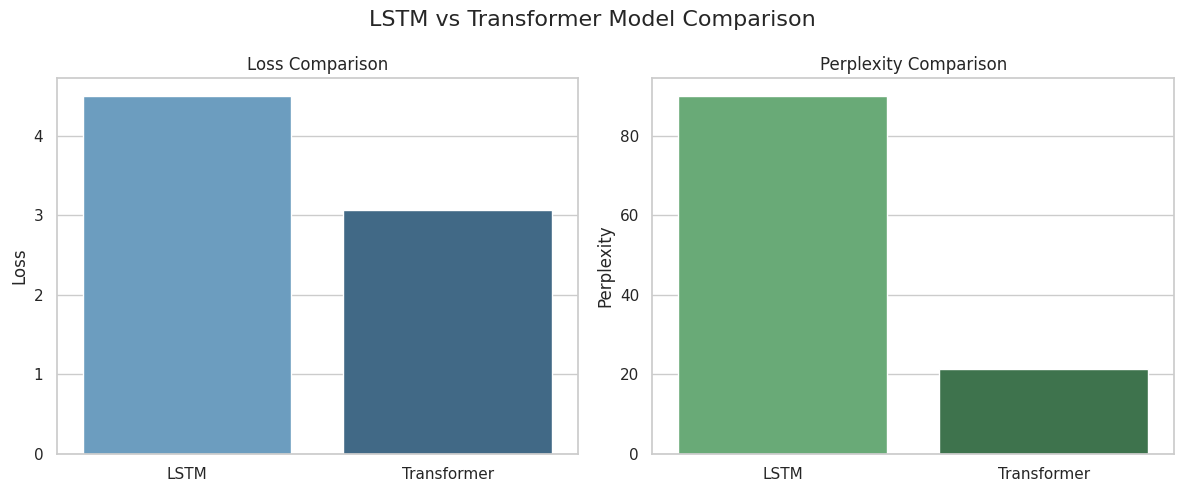

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics from your models
models = ['LSTM', 'Transformer']
losses = [4.5, 3.065]
perplexities = [90, 21.4380]

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss comparison
sns.barplot(x=models, y=losses, ax=axes[0], palette='Blues_d')
axes[0].set_title('Loss Comparison')
axes[0].set_ylabel('Loss')

# Perplexity comparison
sns.barplot(x=models, y=perplexities, ax=axes[1], palette='Greens_d')
axes[1].set_title('Perplexity Comparison')
axes[1].set_ylabel('Perplexity')

plt.suptitle('LSTM vs Transformer Model Comparison', fontsize=16)
plt.tight_layout()
plt.show()


In [15]:
from IPython.display import Markdown, display

display(Markdown("""
###  Model Summary

| Feature            | LSTM                     | Transformer (GPT-2)          |
|--------------------|--------------------------|-------------------------------|
| Sequence Handling  | Sequential (one-step)    | Global (self-attention)       |
| Training Time      | Longer                   | Faster with pre-trained model |
| Output Quality     | Short, less coherent     | Long, context-aware           |
| Perplexity         | 90                     | 21.4380                        |
"""))



###  Model Summary

| Feature            | LSTM                     | Transformer (GPT-2)          |
|--------------------|--------------------------|-------------------------------|
| Sequence Handling  | Sequential (one-step)    | Global (self-attention)       |
| Training Time      | Longer                   | Faster with pre-trained model |
| Output Quality     | Short, less coherent     | Long, context-aware           |
| Perplexity         | 90                     | 21.4380                        |
